# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Данные:
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

Целевая:
* Price — цена (евро)

## Подготовка данных

In [1]:
!pip install phik
!pip install catboost
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import phik
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OrdinalEncoder

pd.options.mode.chained_assignment = None

RANDOM_STATE=77777

In [3]:
try:
    data = pd.read_csv('autos.csv')
except:
    data = pd.read_csv('C:\\Users\\Бозон Хиггса\\Downloads\\autos.csv')

In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
data.sort_values('DateCreated')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
61207,2016-03-16 11:48:06,8999,NaN,2005,NaN,0,147,125000,0,petrol,alfa_romeo,NaN,2014-03-10 00:00:00,0,79669,2016-04-07 04:46:24
4001,2016-03-23 14:42:46,6000,bus,1995,auto,200,other,150000,0,petrol,chevrolet,no,2015-03-20 00:00:00,0,24558,2016-04-07 03:45:01
342275,2016-03-05 21:44:26,10400,bus,1993,NaN,0,ducato,30000,1,gasoline,fiat,NaN,2015-06-18 00:00:00,0,76275,2016-04-05 17:46:09
86601,2016-04-02 19:47:40,14250,convertible,2005,manual,163,slk,150000,6,petrol,mercedes_benz,no,2015-08-07 00:00:00,0,76228,2016-04-07 09:15:23
175103,2016-03-08 17:57:45,5200,convertible,2006,manual,109,2_reihe,80000,11,petrol,peugeot,no,2015-08-10 00:00:00,0,26382,2016-04-05 20:46:54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134418,2016-04-07 06:36:22,30,small,2000,NaN,0,corsa,150000,9,petrol,opel,NaN,2016-04-07 00:00:00,0,88250,2016-04-07 06:36:22
176987,2016-04-07 12:06:36,1800,NaN,2018,manual,150,spider,150000,0,NaN,alfa_romeo,no,2016-04-07 00:00:00,0,61184,2016-04-07 12:25:20
206303,2016-04-07 09:06:21,4300,bus,1998,manual,151,transporter,150000,9,gasoline,volkswagen,NaN,2016-04-07 00:00:00,0,65936,2016-04-07 09:25:17
309336,2016-04-07 06:36:21,500,wagon,1996,NaN,0,a6,150000,0,petrol,audi,yes,2016-04-07 00:00:00,0,59348,2016-04-07 06:36:21


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [8]:
data.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen']

In [9]:
data.duplicated().sum()

4

In [10]:
data.drop_duplicates(inplace=True)

In [11]:
data.duplicated().sum()

0

Удалю столбцы с датами, количеством картинок и почтовым индексом, тк они не влияют на цену автомобиля

In [12]:
data.drop(['date_crawled', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'], axis=1, inplace=True)

In [13]:
data.isna().agg(['sum', 'mean'])

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
sum,0.0,37490.000000,0.0,19833.000000,0.0,19705.000000,0.0,0.0,32895.000000,0.0,71154.000000
mean,0.0,0.105795,0.0,0.055968,0.0,0.055607,0.0,0.0,0.092828,0.0,0.200793


Пропуски в категориальных переменных заполню модой, а информацию была ли машина в ремонте заполню 'no', если не указано, возможно, машина и не была в ремонте

In [14]:
data['repaired'] = data['repaired'].fillna('no')

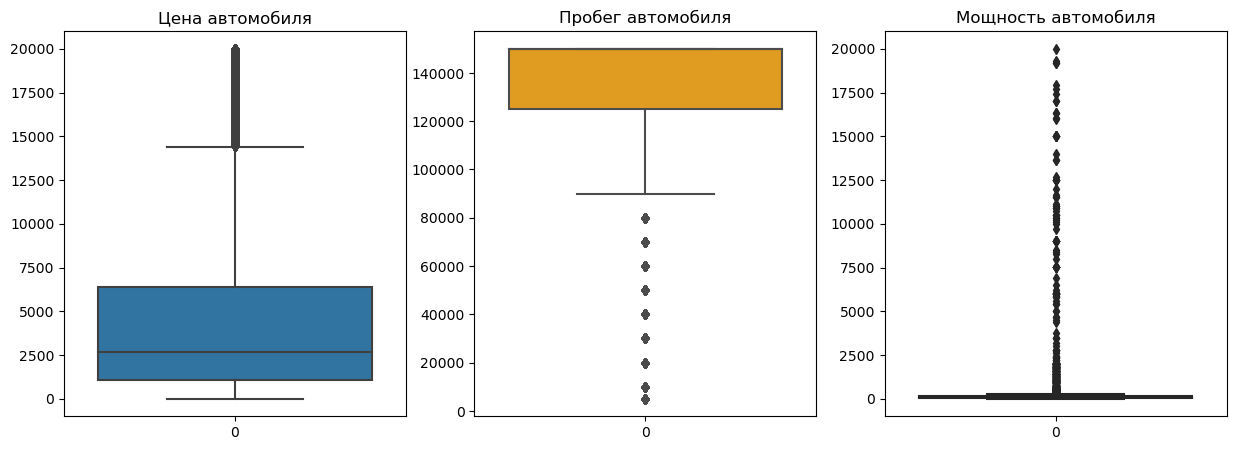

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(data=data['price'], ax=axes[0])
axes[0].set_title('Цена автомобиля')

sns.boxplot(data=data['kilometer'], ax=axes[1], color='orange')
axes[1].set_title('Пробег автомобиля')

sns.boxplot(data=data['power'], ax=axes[2], color='green')
axes[2].set_title('Мощность автомобиля')
plt.show()

Цена в 0 евро смущает сильно, скорее всего, это сделано для того, чтобы покупатели сами предлагали цену. Сделаю минимальный порог в 200 евро, тк, если брать более, то слишком большой объем данных отсеивается.

Мощность в 20000 л.с. это конечно сильно, но не правдоподобно, ограничу 30 и 300.

С пробегом все нормально, выбросов нет. Странно, что 0.5 квантиль совпадает с 0.75 квантилем.

In [16]:
data['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

In [17]:
data.query('power > 300 or power < 30')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,no
15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,no
32,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no
37,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no
40,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,no
...,...,...,...,...,...,...,...,...,...,...,...
354346,2600,NaN,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,no
354360,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,no
354363,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no
354364,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes


In [18]:
data = data.query('price >= 200 and 30 <= power <= 300 and 1930 < registration_year < 2022')

In [19]:
data.shape[0]

299041

In [20]:
for column in ['gearbox', 'model', 'vehicle_type', 'fuel_type']:
    data[column] = data[column].fillna(data[column].mode()[0])

In [21]:
data.describe()

,price,registration_year,power,kilometer,registration_month
count,299041.000000,299041.000000,299041.000000,299041.000000,299041.000000
mean,4803.003859,2003.401463,118.699125,128477.767263,5.983641
std,4526.268245,6.820848,48.510342,36542.052175,3.590945
min,200.000000,1931.000000,30.000000,5000.000000,0.000000
25%,1380.000000,1999.000000,76.000000,125000.000000,3.000000
50%,3150.000000,2003.000000,110.000000,150000.000000,6.000000
75%,6900.000000,2008.000000,149.000000,150000.000000,9.000000
max,20000.000000,2019.000000,300.000000,150000.000000,12.000000


In [22]:
print(data.duplicated().sum())
data.drop_duplicates(inplace=True)

27707


In [23]:
data.shape[0]

271334

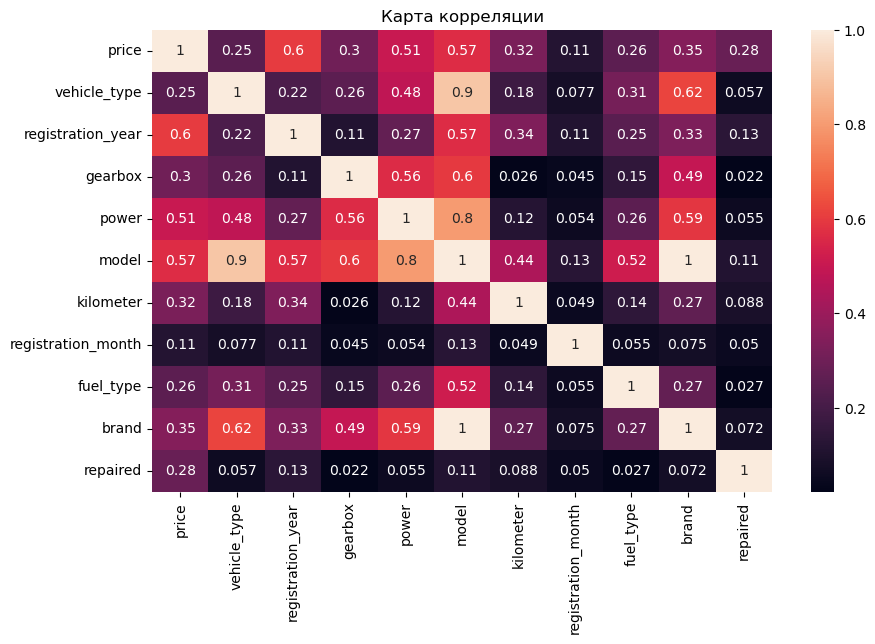

In [24]:
plt.figure(figsize=(10,6))
sns.heatmap(data.phik_matrix(interval_cols=['price', 'registration_year', 'power', 'kilometer', 'registration_month']), annot=True)
plt.title('Карта корреляции')
plt.show()

In [25]:
data.drop(['model'], axis=1, inplace=True)

In [26]:
1 - 271334/354369

0.23431790026779997

**Вывод:** Удалены неинформативные признаки - дата скачивания анкеты из базы (база была скачана в течении получаса), дата создания анкеты (интервал анкет - месяц), количество картинок, почтовый индекс владельца, дата последней активности пользователя.

Удалены аномальные выбросы, теперь данные ограничены:
- Цена больше или равна 200;
- Мощность меньше 300;
- Год регистрации автомобиля в диапазоне 1930 и 2022.

Категориальные пропуски заполнены модой.

Высокая корреляция между моделью и типом кузова и очень высокая между маркой автомобиля и моделью, поэтому удален признак с моделью.

После обработки было удалено 23 процента данных.

## Обучение моделей

Разделение датасета на тренировочную выборку 60%, валидационную 20% и тестовую 20%.

In [27]:
features = data.drop(['price'], axis=1)
target = data['price']

In [28]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=.4, random_state=RANDOM_STATE)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=.5, random_state=RANDOM_STATE)
print(f'Кол-во строк трейн: {target_train.shape[0]} \nКол-во строк валид: {target_valid.shape[0]} \nКол-во строк тест: {target_test.shape[0]}')

Кол-во строк трейн: 162800 
Кол-во строк валид: 54267 
Кол-во строк тест: 54267


In [29]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [30]:
cat_features = list(features_train.loc[:, features_train.dtypes == 'object'].columns.values)
print(cat_features)

['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired']


In [31]:
encoder.fit(features_train[cat_features])

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [32]:
features_train[cat_features] = encoder.transform(features_train[cat_features]).astype(int)

In [33]:
features_train

,vehicle_type,registration_year,gearbox,power,kilometer,registration_month,fuel_type,brand,repaired
255835,5,2013,1,75,30000,12,6,38,0
307282,4,1991,1,174,150000,10,6,1,0
9787,5,1999,0,150,150000,3,6,38,0
69881,2,2009,0,231,125000,7,2,20,0
122267,6,2005,0,204,150000,2,2,2,0
...,...,...,...,...,...,...,...,...,...
268477,4,2000,1,116,150000,9,2,38,0
86385,5,2008,1,54,60000,1,6,38,0
41557,5,2002,1,64,150000,2,6,38,0
75154,5,1997,1,75,150000,3,6,38,0


In [34]:
features_valid[cat_features] = encoder.transform(features_valid[cat_features]).astype(int)

features_test[cat_features] = encoder.transform(features_test[cat_features]).astype(int)

### Случайный лес

In [35]:
%%time
model_randomforest = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=RANDOM_STATE)

Wall time: 0 ns


In [36]:
%%time
model_randomforest.fit(features_train, target_train)

Wall time: 23.1 s


RandomForestRegressor(max_depth=20, random_state=77777)

In [37]:
%%time
predict_randomforest = model_randomforest.predict(features_valid)

Wall time: 1.06 s


In [38]:
%%time
rmse_randomforest = mean_squared_error(target_valid, predict_randomforest, squared=False)
print(rmse_randomforest)

1693.3137571051982
Wall time: 1 ms


### CatBoost

In [39]:
%%time
model_catboost_50 = CatBoostRegressor(learning_rate=.5, iterations=50, depth=14, random_seed=RANDOM_STATE, cat_features=cat_features)

Wall time: 0 ns


In [40]:
%%time
model_catboost_50.fit(features_train, target_train, verbose=20)

0:	learn: 2980.9001106	total: 414ms	remaining: 20.3s
20:	learn: 1547.4522516	total: 5.74s	remaining: 7.92s
40:	learn: 1433.2255313	total: 10.1s	remaining: 2.22s
49:	learn: 1395.7168978	total: 12.2s	remaining: 0us
Wall time: 12.6 s


In [41]:
%%time
predict_catboost_50 = model_catboost_50.predict(features_valid)

Wall time: 76 ms


In [42]:
%%time
rmse_catboost_50 = mean_squared_error(target_valid, predict_catboost_50, squared=False)
print(rmse_catboost_50)

1672.5288603636438
Wall time: 993 µs


In [43]:
%%time
model_catboost_100 = CatBoostRegressor(learning_rate=.5, iterations=100, depth=14, random_seed=RANDOM_STATE, cat_features=cat_features)

Wall time: 0 ns


In [44]:
%%time
model_catboost_100.fit(features_train, target_train, cat_features=cat_features, verbose=20)

0:	learn: 2980.9001106	total: 258ms	remaining: 25.6s
20:	learn: 1547.4522516	total: 5.13s	remaining: 19.3s
40:	learn: 1433.2255313	total: 9.43s	remaining: 13.6s
60:	learn: 1367.7547961	total: 14.1s	remaining: 8.98s
80:	learn: 1308.6195189	total: 18.6s	remaining: 4.36s
99:	learn: 1259.5858121	total: 22.8s	remaining: 0us
Wall time: 23.2 s


In [45]:
%%time
predict_catboost_100 = model_catboost_100.predict(features_valid)

Wall time: 75.9 ms


In [46]:
%%time
rmse_catboost_100 = mean_squared_error(target_valid, predict_catboost_100, squared=False)
print(rmse_catboost_100)

1672.9348199358035
Wall time: 1 ms


### LightGBM

In [47]:
%%time
model_lgbm_1000 = LGBMRegressor(min_child_samples=50, n_estimators=1000, max_depth=20, learning_rate=.1, num_leaves=100, random_state=RANDOM_STATE)

Wall time: 0 ns


In [48]:
%%time
model_lgbm_1000.fit(features_train, target_train)

Wall time: 2.24 s


LGBMRegressor(max_depth=20, min_child_samples=50, n_estimators=1000,
              num_leaves=100, random_state=77777)

In [49]:
%%time
predict_lgbm_1000 = model_lgbm_1000.predict(features_valid)

Wall time: 407 ms


In [50]:
%%time
rmse_lgbm_1000 = mean_squared_error(target_valid, predict_lgbm_1000, squared=False)
print(rmse_lgbm_1000)

1607.2882426151277
Wall time: 1e+03 µs


In [51]:
%%time
model_lgbm_500 = LGBMRegressor(min_child_samples=50, n_estimators=500, max_depth=20, learning_rate=.1, num_leaves=100, random_state=RANDOM_STATE)

Wall time: 0 ns


In [52]:
%%time
model_lgbm_500.fit(features_train, target_train)

Wall time: 1.28 s


LGBMRegressor(max_depth=20, min_child_samples=50, n_estimators=500,
              num_leaves=100, random_state=77777)

In [53]:
%%time
predict_lgbm_500 = model_lgbm_500.predict(features_valid)

Wall time: 157 ms


In [54]:
%%time
rmse_lgbm_500 = mean_squared_error(target_valid, predict_lgbm_500, squared=False)
print(rmse_lgbm_500)

1605.492134569593
Wall time: 1 ms


### Анализ моделей

In [55]:
pd.DataFrame({
    'Время обучения': ['23.1 s', '12.6 s', '23.2 s', '2.24 s', '1.28 s'],
    'Время предсказания': ['1.06 s', '76 ms', '75.9 ms', '407 ms', '157 ms'],
    'RMSE': [int(i) for i in [rmse_randomforest, rmse_catboost_50, rmse_catboost_100, rmse_lgbm_1000, rmse_lgbm_500]]
},
    index=['RandomForest', 'CatBoost 50', 'CatBoost 100', 'LGBM 1000', 'LGBM 500']
)

,Время обучения,Время предсказания,RMSE
RandomForest,23.1 s,1.06 s,1693
CatBoost 50,12.6 s,76 ms,1672
CatBoost 100,23.2 s,75.9 ms,1672
LGBM 1000,2.24 s,407 ms,1607
LGBM 500,1.28 s,157 ms,1605


**Вывод:** Лучше всего себя показала модель LGBMRegressor с гиперпараметрами:
* min_child_samples=50;
* n_estimators=500;
* max_depth=20;
* learning_rate=.1;
* num_leaves=100.

Она обучилась всего за 2.24 секунды, время предсказания менее секунды (407 мс) показала наилучшее качество обучения - RMSE 1605 на валидационной выборке.

## Лучшая модель

In [56]:
%%time
mean_squared_error(target_test, model_lgbm_500.predict(features_test), squared=False)

Wall time: 166 ms


1581.1086968022196

**Вывод:** Удалены неинформативные признаки - дата скачивания анкеты из базы (база была скачана в течении получаса), дата создания анкеты (интервал анкет - месяц), количество картинок, почтовый индекс владельца, дата последней активности пользователя.

Удалены аномальные выбросы, теперь данные ограничены:
- Цена больше или равна 200;
- Мощность меньше 300;
- Год регистрации автомобиля в диапазоне 1930 и 2022.

Категориальные пропуски заполнены модой, кроме информации о ремонте - заполнено отрицательным ответом.

Высокая корреляция между моделью и типом кузова и очень высокая между маркой автомобиля и моделью, поэтому удален признак с моделью.

После обработки было утеряно 23% данных.

Оставшиеся данные были поделяны на обучающую, равную 60%, валидационную - 20% и тестовую - 20% выборки.

Для поиска лучшей модели были задействованы 3 вида алгоритма - RandomForestRegressor, CatBoostRegressor и LGBMRegressor - с разными гиперпараметрами. По итогу на валидационной выборке, лучший результат выдала модель LGBMRegressor - RMSE 1605.

На тестовой выборке модель показала RMSE 1581.